In [9]:
library('data.table')
library('extraDistr')
library('foreach')

source('tplotfunctions.R')
source('guessmetadata.R')
source('buildagent.R')
source('infer.R')
source('decide.R')
source('mutualinfo.R')
source('rF.R')
source('plotFsamples1D.R')

## Modify '10' below if the plots are too large or too small
options(repr.plot.width=10*sqrt(2), repr.plot.height=10)

# How the optimal predictor machine deals with irrelevant variates

Load the reduced dataset with only the variates *income*, *marital_status*, *relationship*, and their metadata

In [11]:
traindata <- fread('train-reduced_income_data_example.csv', header=T)

metadata <- fread('meta_reduced_income_data_example.csv', header=T)
metadata$variate

[1] "marital_status" "relationship"   "income"

Create values of a new variate *silly*, completely unrelated with those of the dataset. Then create a new dataset & metadata with this additional variate

In [12]:
sillyvar <- sample(c('cat','dog'), nrow(traindata), replace=T, prob=c(0.75,0.25))

traindatasilly <- cbind(traindata, data.table(silly=sillyvar))

metadatasilly <- rbind(metadata,list('silly', 2, 'cat', 'dog'), fill=T)

Train one agent with the proper data, and another agent with the data including the irrelevant variate

In [13]:
opm <- buildagent(metadata=metadata, data=traindata)

opmsilly <- buildagent(metadata=metadatasilly, data=traindatasilly)

Let the agent trained with the extra variate calculate the mutual information of all variates with *income*.

In [14]:
## list of all variates
variates <- names(dimnames(opmsilly$counts))

## list of all variates except 'income'
predictors <- variates[variates != 'income']

## prepare vector to contain the mutual information
relevances <- numeric(length(predictors))
names(relevances) <- predictors

## calculate, for each variate,
## the joint probability distribution 'probs'
## and then mutual information 'relevance' (in shannons)
## between 'income' and that variate
for(var in predictors){
    probs <- infer(agent=opmsilly, predictand=c('income',var))
    relevances[var] <- mutualinfo(probs=probs, A='income', B=var)
}

## output the mutual informations in decreasing order
print(sort(relevances, decreasing=TRUE))

  relationship marital_status          silly 
  0.1583697785   0.1499698841   0.0000117712 


We see that the extra, irrelevant variate has a very small mutual information with *income*.

Define two predictor variates

In [15]:
datum <- list(marital_status='Divorced', relationship='Not-in-family')

In [22]:
datumcat <- c(datum, list(silly='cat'))
datumdog <- c(datum, list(silly='dog'))

In [18]:
infer(agent=opm, predictand='income', predictor=datum)

income
   <=50K     >50K 
0.871472 0.128528

In [19]:
infer(agent=opmsilly, predictand='income', predictor=datum)

income
   <=50K     >50K 
0.871395 0.128605

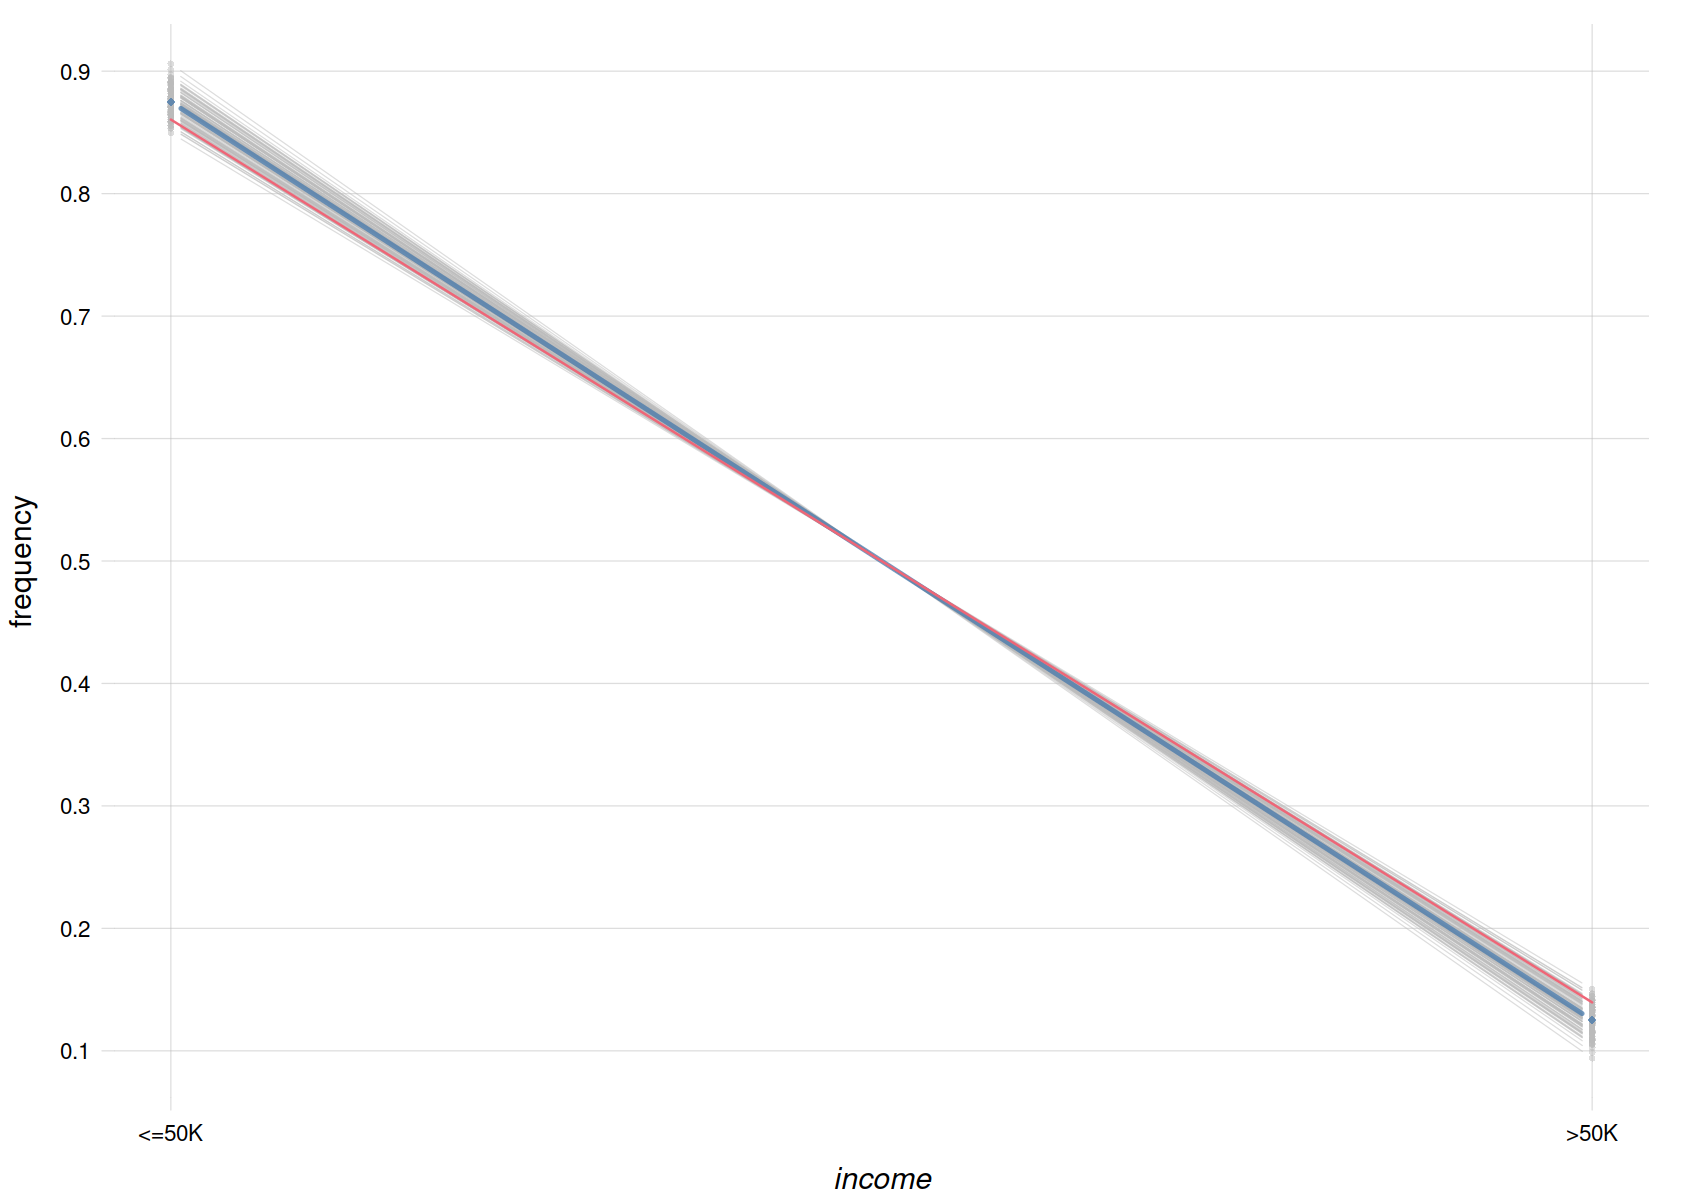

In [23]:
plotFsamples1D(agent=opmsilly, predictand='income', predictor=datumcat)

withdog <- infer(agent=opmsilly, predictand='income', predictor=datumdog)
tplot(x=names(withdog),y=withdog,col=2,add=T)